# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
from DYNASMART_Process import *
import DYNASMART_Process as dy
import AV_functions as av
from gurobipy import *

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
# personData=pd.read_csv('input/personData_1.csv')
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

### Draw the sub-area network

C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

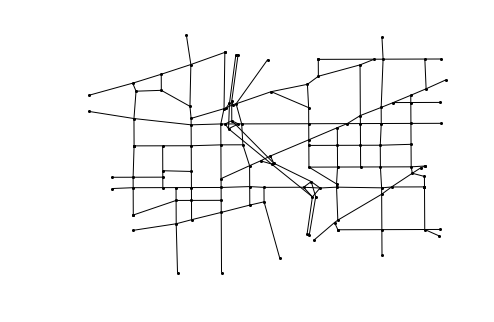

In [3]:
cluster_highlight([])

### Sample Household
Select household 2105189 for intial analysis

In [4]:
traveler_trips.head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,dest_maz,dest_taz,starttimeinterval,starttime,hh_id,origin_node,destination_node
0,8600957,11,0.1164,1,24.0,1,Home,Shop,1,1,62,16,1,1.0,2744264,9675,10757
1,8600957,11,0.1164,2,32.0,3,Shop,eatingout,62,16,20,5,1,31.0,2744264,10542,10057
2,8600957,11,0.1164,3,39.0,1,eatingout,Maintenance,20,5,3,1,1,68.0,2744264,9864,9675
3,8600957,11,0.1164,4,198.0,3,Maintenance,Home,3,1,1,1,1,109.0,2744264,9674,9737
4,8600957,11,0.1164,5,191.0,1,Home,work,1,1,14,4,8,308.0,2744264,9738,9673


10
9


C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Alex\Anaconda3\envs\py35\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.ho

4
7


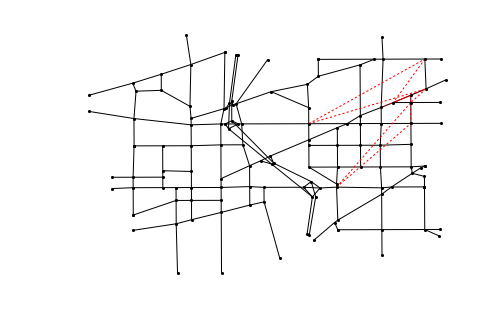

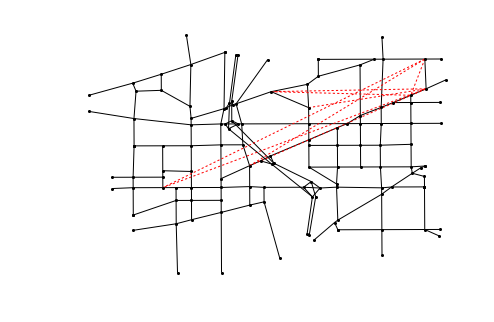

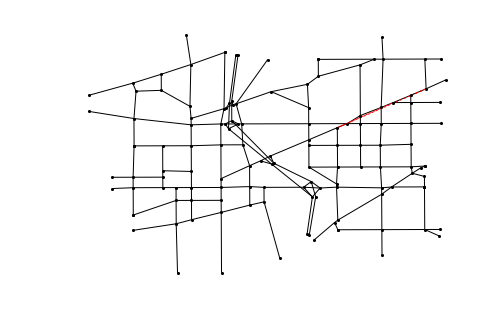

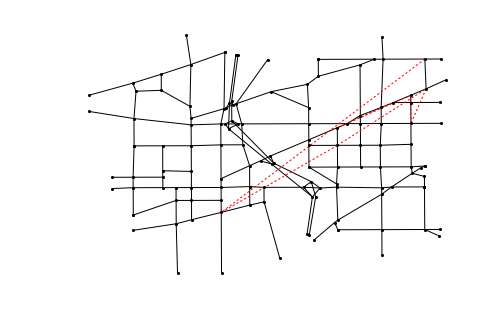

In [5]:
target_hh=2105189
people_in_hh=traveler_trips[traveler_trips['hh_id']==2105189]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

Visulization the sample household activity chains

In [6]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

In [7]:
target_hh.to_csv('target_hh.csv')

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

In [8]:
household=2105189
hh_members=traveler_trips[traveler_trips['hh_id']==household]['person_id'].unique()
hh_num_trips=traveler_trips[traveler_trips['hh_id']==household]['num_trips'].value_counts().sum()
num_hh_member=hh_members.size
#x=np.zeros([2*hh_num_trips+2,2*hh_num_trips+2])
#T=np.zeros(2*hh_num_trips)
R=np.ones(hh_num_trips+1)*15
#S=np.ones(hh_num_trips)
#Calculate the distance matrix between all node pairs
# C=np.ones(2*hh_num_trips+2,2*hh_num_trips+2)
np.random.seed(1)
C=np.random.rand(2*hh_num_trips+2,2*hh_num_trips+2)*10
visit_candidate=[traveler_trips[traveler_trips['hh_id']==household]['origin_node'].iloc[0]]
visit_candidate.extend(traveler_trips[traveler_trips['hh_id']==household]['origin_node'].tolist())
visit_candidate.extend(traveler_trips[traveler_trips['hh_id']==household]['destination_node'].tolist())
visit_candidate.extend([traveler_trips[traveler_trips['hh_id']==household]['origin_node'].iloc[0]])
C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*10

In [9]:
np.histogram(C)

(array([3782,    0,    0,    0,    0,    0,    0,    0,    0,   62], dtype=int64),
 array([     0.,   2000.,   4000.,   6000.,   8000.,  10000.,  12000.,
         14000.,  16000.,  18000.,  20000.]))

In [10]:

# #Initialize the decision varibales
# m1=Model("AVSchedule")
# x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
# T=m1.addVars(2*hh_num_trips+2,name="T")
# # S=m1.addVars(hh_num_trips+1,name="S")
# B=2000
# #Add constraints
# ###################################
# #Basic deliver and pickup constraints
# m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
# m1.addConstrs((x[i,0]==0 for i in range(2*hh_num_trips+2)))
# m1.addConstrs((x.sum('*',i)==1 for i in [2*hh_num_trips+1]),"ToDepot3") 
# m1.addConstrs((x[2*hh_num_trips+1,i]==0 for i in range(2*hh_num_trips+2)))
# m1.addConstrs((x.sum(i,"*")==x.sum("*",i+hh_num_trips) for i in range(1,hh_num_trips+1)),"DemandbeDelivered11")
# m1.addConstrs((x.sum(i,"*")<=1 for i in range(2*hh_num_trips+1)),"DemandOnce12")
# m1.addConstrs((x.sum("*",j)<=1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")

# # m1.addConstrs((x.sum("*",i)==x.sum(i,"*") for i in range(1,2*hh_num_trips+1)),"FlowConvervative14")
# m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)),"NoDoubleVisit")
# # ###################################
# # #Time constratins
# m1.addConstrs(T[i]==traveler_trips[traveler_trips['hh_id']==household]['starttime'].min() for i in [0])
# m1.addConstrs((T[j]-T[i]-B*x[i,j]>=C[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
# m1.addConstrs(T[i]<=1440 for i in range(2*hh_num_trips+2))
# # # m1.addConstrs((T[i+hh_num_trips]-T[i]-B*x.sum(i,"*")>=(C[i,i+hh_num_trips]-B) for i in range(1,hh_num_trips+1)),"deliverafterpickup16")
# # ####################################
# # #Late/Early Arrival penalty
# # # m1.addConstrs(S[i]<=1 for i in range(31))

# obj1=sum(x.sum(i,'*')*R[i] for i in range(hh_num_trips+1))
# # obj2=S.sum()
# obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
# # m1.setObjective(obj1+obj2-obj3, GRB.MAXIMIZE)
# m1.setObjective(obj1-obj3,GRB.MAXIMIZE)
# m1.optimize()

In [18]:
#Solve the Single vehicle pickup and delivery problem 
#Initialize the decision varibales
m1=Model("AVSchedule")
x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
T=m1.addVars(2*hh_num_trips+2,name="T")

B=40000
#Add constraints
###################################
#Basic deliver and pickup constraints

m1.addConstrs((x.sum("*",j)==1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")
m1.addConstrs((x.sum(i,"*")==1 for i in range(2*hh_num_trips+1)),"DemandOnce12")
m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
m1.addConstrs((x[i,0]==0 for i in range(2*hh_num_trips+2)))
m1.addConstrs((x[2*hh_num_trips+1,i]==0 for i in range(2*hh_num_trips+2)))
# m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)))

# ###################################
# #Time constratins
m1.addConstrs(T[i]==traveler_trips[traveler_trips['hh_id']==household]['starttime'].min() for i in [0])
m1.addConstrs((T[j]-T[i]-B*x[i,j]>=C[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
m1.addConstrs(T[i]<=1440 for i in range(1,2*hh_num_trips+1))
m1.addConstrs(T[i]>=129 for i in range(1,2*hh_num_trips+1))
# # m1.addConstrs(T[i]<=1440 for i in range(2*hh_num_trips+2))
# m1.addConstrs((T[i+hh_num_trips]-T[i]>=C[i,i+hh_num_trips] for i in range(1,hh_num_trips+1)),"deliverafterpickup16")

obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
# m1.setObjective(obj1+obj2-obj3, GRB.MAXIMIZE)
m1.setObjective(-obj3,GRB.MAXIMIZE)
m1.optimize()

Optimize a model with 4212 rows, 3906 columns and 19279 nonzeros
Variable types: 62 continuous, 3844 integer (3844 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [1e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 503 rows and 185 columns
Presolve time: 0.03s
Presolved: 3709 rows, 3721 columns, 18036 nonzeros
Variable types: 60 continuous, 3661 integer (3661 binary)
Found heuristic solution: objective -966.6297316

Root relaxation: objective -8.572934e+01, 194 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -85.72934    0   43 -966.62973  -85.72934  91.1%     -    0s
H    0     0                    -258.4366683  -85.72934  66.8%     -    0s
     0     0 -125.40274    0   45 -258.43667 -125.40274  51.5%     -    0s
     0     0 -125.40274    0   49 -258.43667 -1

#### (traveler_trips[traveler_trips['hh_id']==household]['starttime'].iloc[1-1]+120)

In [ ]:
print(C.max(),C.min())

In [ ]:
C[0,1]

In [ ]:
C[1,1]

In [ ]:
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        print(i,j,C[i,j])

In [ ]:
for v in m1.getVars():
     if (v.x !=0):
        print(v.varName, v.x)        

In [ ]:
#Check the feasibility of the answer
route_dic={}
counter=0
for i in range(2*hh_num_trips+2):
    for j in range(2*hh_num_trips+2):
        if x[i,j].x==1:
            route_dic[i]=j
            counter=counter+1
            
print("there are ",counter," trips")
route=[3]

for i in range(len(route_dic)):
    route.extend([route_dic[route[i]]])
    print(route[i],route_dic[route[i]] )#,C[route[i],route_dic[route[i]]],T[route[i]])

In [ ]:
T[3]

In [ ]:
route

In [ ]:
len(route_dic)

In [ ]:
m1.getVars()